In [1]:
%%bash
pwd
mkdir -p "./data/outputs"

/home/jordan990301/Projects/HiCPAP/examples


In [2]:
import numpy as np
import pandas as pd
from hicpap import paptools

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=50)

In [3]:
### Case 1
kwargs = {
    "pearson":  "./data/juicer_data/gm12878_1000000_pearson_chr1.txt",
    "zero_mean": True 
}
pearson_np = paptools.read_pearson(**kwargs)

### Case 2
# kwargs = {
#     "hic_path": "https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic",
#     "chrom_x": "1",
#     "chrom_y": "1",
#     "resolution": 1000000,
#     "norm": "KR",
#     "method": "oe",
#     "zero_mean": True 
# }
# pearson_np = paptools.straw_to_pearson(**kwargs)

display(pearson_np)

array([[ 1.0476,  0.1936,  0.0028, ...,  0.0101,  0.4535,  0.8902],
       [ 0.2667,  1.1206,  0.5389, ..., -0.3489, -0.4613, -0.1819],
       [ 0.0411,  0.5042,  1.086 , ..., -0.443 , -0.3807, -0.2496],
       ...,
       [-0.1431, -0.5751, -0.6345, ...,  0.8944,  0.7085,  0.3035],
       [ 0.3187, -0.6692, -0.5538, ...,  0.7269,  0.9128,  0.6856],
       [ 0.8164, -0.3288, -0.3617, ...,  0.3829,  0.7466,  0.9738]])

In [4]:
output = "./data/outputs/gm12878_1000000_approx_pc1.txt"
approx_np = paptools.create_approx(pearson_np=pearson_np, output=output)
display(approx_np)

array([ 0.1182, -0.3513, -0.2252, ...,  0.2936,  0.3887,  0.2949])

In [5]:
Vh, explained_variances, total_entry_num, valid_entry_num = paptools.pca_on_pearson(pearson_np=pearson_np)
pc1_np = Vh[0]
pc2_np = Vh[1]
pc3_np = Vh[2]

display(f"pc1_np: {pc1_np}")
display(f"pc2_np: {pc2_np}")
display(f"pc3_np: {pc3_np}")
display(f"explained_variances: {explained_variances}")
display(f"total_entry_num: {total_entry_num}")
display(f"valid_entry_num: {valid_entry_num}")

'pc1_np: [-0.0241  0.0759  0.0487 ... -0.0633 -0.083  -0.0624]'

'pc2_np: [-0.0536 -0.0055 -0.1206 ...  0.0592 -0.0076 -0.0192]'

'pc3_np: [ 0.1081  0.0879 -0.0366 ...  0.039   0.0504  0.0846]'

'explained_variances: [0.8449 0.0699 0.0404 ... 0.     0.     0.    ]'

'total_entry_num: 250'

'valid_entry_num: 230'

In [6]:
correctness_info = paptools.calc_correctness(pc1_np=pc1_np, approx_np=approx_np)
display(correctness_info)

{'total_entry_num': 250,
 'valid_entry_num': 230,
 'correct_num': 228,
 'correct_rate': 0.991304347826087}

In [7]:
kwargs_2 = {
    "pc1_np": pc1_np,
    "approx_np": approx_np,
    "figsize": 20,
    "scatter": "./data/outputs/gm12878_1000000_scatter.png",
    "relative_magnitude": "./data/outputs/gm12878_1000000_relative_magnitude.png",
}
paptools.plot_comparison(**kwargs_2)

compare with juicer pc1

In [8]:
pc1 = "./data/juicer_data/gm12878_1000000_pc1_chr1.txt"
pc1_df = pd.read_table(pc1, header=None)
pc1_np = pc1_df.fillna(0).values.flatten()

correctness_info = paptools.calc_correctness(pc1_np=pc1_np, approx_np=approx_np)
display(correctness_info)

{'total_entry_num': 250,
 'valid_entry_num': 230,
 'correct_num': 225,
 'correct_rate': 0.9782608695652174}

flip track

In [9]:
gc_df = pd.read_table("./data/reference/hg19_gc_cov_1000000.tsv")

# print(f'Before flip: {approx_np}')
approx_np = paptools.flip_track(track1_np=approx_np, track2_np=approx_np, gc_df=gc_df, chrom="1")
# print(f'After flip: {approx_np}')

20


Heatmap

[]

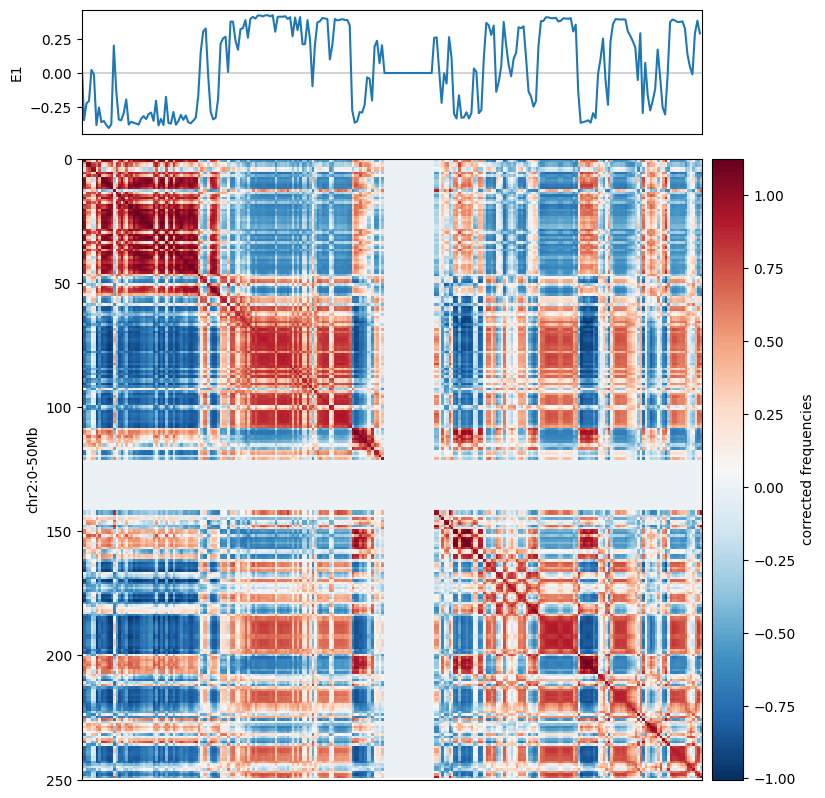

In [10]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(
    figsize=(15, 10),
)

im = ax.matshow(
    pearson_np,
    cmap='RdBu_r',
)
plt.axis([0,len(approx_np),len(approx_np),0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies')
ax.set_ylabel('chr2:0-50Mb')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
ax1.plot([0,len(approx_np)],[0,0],'k',lw=0.25)
ax1.plot(approx_np, label='E1')

ax1.set_ylabel('E1')
ax1.set_xticks([])